# Multi-modal Search on the Amazon Reviews Dataset


## Introduction

The [_Amazon Product Dataset_](http://jmcauley.ucsd.edu/data/amazon/links.html) contains product metadata, reviews, and image feature vectors for 9.4 million Amazon products. The dataset was collected by researchers at UCSB. For more information, see the paper _Justifying recommendations using distantly-labeled reviews and fined-grained aspects_ by Jianmo Ni, Jiacheng Li, and Julian McAuley. 

In this tutorial, we'll use the metadata and image feature vectors from the "Home and Kitchen" category to demonstrate how Elastiknn can be used for multi-modal search. Specifically, we will search for products using simple keywords, search for similar products based on images, and search for similar products based on combinations of keywords and product images.

The tutorial assumes you are comfortable with Python and the Elasticsearch JSON API and have successfully [installed Elastiknn](https://elastiknn.com/installation/).

## Download the Data

Download two files:

1. meta_Home_and_Kitchen.json.gz - contains the product metadata.
2. image_features_Home_and_Kitchen.b - contains pre-computed image vectors.

In [1]:
!wget -nc http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/meta_Home_and_Kitchen.json.gz
!wget -nc http://snap.stanford.edu/data/amazon/productGraph/image_features/categoryFiles/image_features_Home_and_Kitchen.b    

File ‘meta_Home_and_Kitchen.json.gz’ already there; not retrieving.

File ‘image_features_Home_and_Kitchen.b’ already there; not retrieving.



## Explore the Data

Let's have a look at the data. 

The `amazonutils` module includes functions for iterating over the data. Let's first import that and some others.

In [8]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from amazonutils import *
from itertools import islice
from tqdm import tqdm
from pprint import pprint
from IPython.display import Image, display, Markdown
import matplotlib.pyplot as plt
import numpy as np

fname_products = "meta_Home_and_Kitchen.json.gz"
fname_vectors = "image_features_Home_and_Kitchen.b"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


First we'll iterate over the metadata for a few products. Notice each product's metadata is a dictionary containing a title, description, image url, etc. We'll display the images using the URL.

{'asin': '0076144011',
 'categories': [['Home & Kitchen']],
 'imUrl': 'http://g-ecx.images-amazon.com/images/G/01/x-site/icons/no-img-sm._CB192198896_.gif',
 'salesRank': {'Books': 6285595},
 'title': 'Ninjas, Piranhas, and Galileo'}


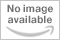

{'asin': '0130350591',
 'categories': [['Home & Kitchen',
                 'Kitchen & Dining',
                 'Dining & Entertaining',
                 'Serveware',
                 'Butter Dishes']],
 'imUrl': 'http://ecx.images-amazon.com/images/I/21zcx6RCDoL.jpg',
 'salesRank': {'Kitchen & Dining': 459680},
 'title': 'Le Creuset Kiwi (Green) Butter Dish Stoneware'}


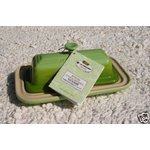

{'asin': '0307394530',
 'brand': 'Random House',
 'categories': [['Home & Kitchen', 'Artwork', 'Posters & Prints']],
 'imUrl': 'http://ecx.images-amazon.com/images/I/51A4FWujzgL._SY300_.jpg',
 'price': 14.99,
 'salesRank': {'Arts, Crafts & Sewing': 3597},
 'title': "Martha Stewart's Wedding Cakes"}


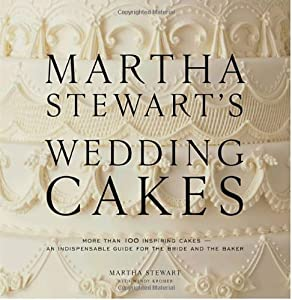

{'asin': '0439903491',
 'categories': [['Home & Kitchen', 'Artwork', 'Posters & Prints']],
 'imUrl': 'http://ecx.images-amazon.com/images/I/61tVxckoYUL._SY300_.jpg',
 'price': 29.99,
 'salesRank': {'Software': 7065}}


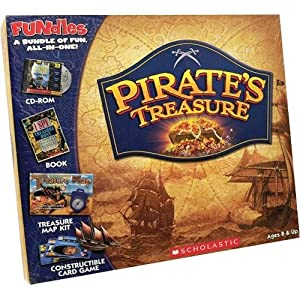

{'asin': '0578060604',
 'categories': [['Home & Kitchen',
                 'Furniture',
                 'Kitchen & Dining Room Furniture',
                 'Chairs']],
 'imUrl': 'http://ecx.images-amazon.com/images/I/41aCELWJgWL._SY300_.jpg',
 'title': 'Build A Maloof Inspired Low Back Dining Chair with Charles Brock'}


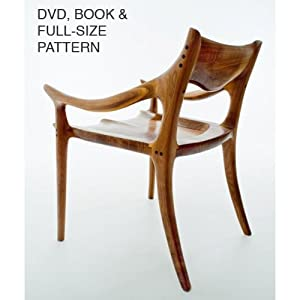

{'asin': '0587234792',
 'categories': [['Home & Kitchen', 'Artwork', 'Posters & Prints']],
 'imUrl': 'http://ecx.images-amazon.com/images/I/51DPFpHmhuL._SX300_.jpg',
 'salesRank': {'Home &amp; Kitchen': 4867920},
 'title': '&quot;Coos Bay Lighthouse&quot; Print (Canvas 20x30)'}


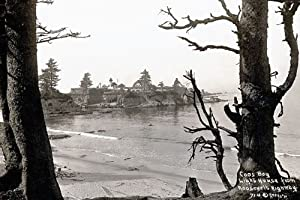

{'asin': '0587010584',
 'categories': [['Home & Kitchen', 'Artwork', 'Posters & Prints']],
 'imUrl': 'http://ecx.images-amazon.com/images/I/41W9TsKkY5L._SY300_.jpg',
 'price': 16.95,
 'salesRank': {'Home &amp; Kitchen': 3727362},
 'title': "Marionette Theater Presents RUR (Rossum's Universal Robots)"}


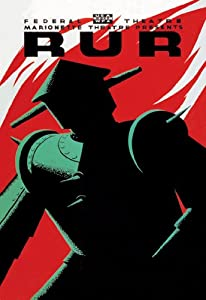

{'asin': '0587168978',
 'brand': 'Buyenlarge',
 'categories': [['Home & Kitchen', 'Artwork', 'Posters & Prints']],
 'imUrl': 'http://ecx.images-amazon.com/images/I/415hRb4C0TL._SX300_.jpg',
 'price': 26.72,
 'salesRank': {'Home &amp; Kitchen': 1707155},
 'title': '&quot;Daybreak&quot; Print (Unframed Paper Print 20x30)'}


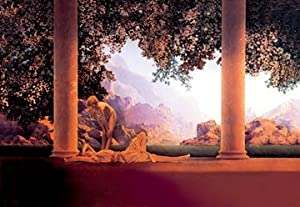

{'asin': '0587218959',
 'brand': 'Buyenlarge',
 'categories': [['Home & Kitchen', 'Artwork', 'Posters & Prints']],
 'imUrl': 'http://ecx.images-amazon.com/images/I/310M9-V-RrL.jpg',
 'price': 11.88,
 'salesRank': {'Home &amp; Kitchen': 3882566},
 'title': 'Look Pretty Have Fun - 12x18 Art Poster by Fashion Frocks'}


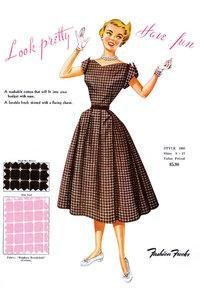

{'asin': '0587217189',
 'brand': 'Buyenlarge',
 'categories': [['Home & Kitchen', 'Artwork', 'Posters & Prints']],
 'imUrl': 'http://ecx.images-amazon.com/images/I/51j27YQPyTL._SY300_.jpg',
 'price': 16.95,
 'salesRank': {'Home &amp; Kitchen': 4172092},
 'title': 'The Great McEwen, famous Scottish hypnotist 20x30 Poster Paper'}


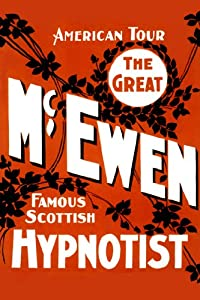

In [16]:
for p in islice(iter_products(fname_products), 10):
    pprint({k:v for (k,v) in p.items() if k not in {'related', 'description'}})
    display(Image(p['imUrl'], width=128, height=128))

Next we'll use the `iter_vectors` function to iterate over product IDs and image vectors. Each vector is just a list of 4096 floats, generated using a deep convolutional neural network.

There's not much value in inspecting the individual vectors, so we'll just show the first few values for each one. 

Then we'll sample a subset of vectors and plot the distribution of values. Note that there are many zeros. This will be important later on.

B0007Y05RW [0.0, 3.7047998905181885, 2.638200044631958, 0.0, 0.0] ...
B000BMIAO0 [0.0, 1.323199987411499, 0.0, 0.0, 2.02020001411438] ...
B000FMJ3YM [0.0, 0.0, 2.499300003051758, 0.0, 0.0] ...


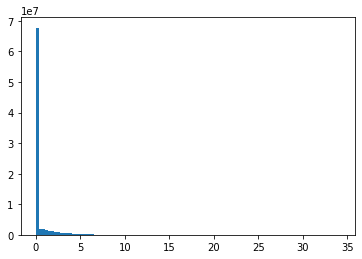

In [4]:
for (asin, vec) in islice(iter_vectors(fname_vectors), 3):
    print(asin, vec[:5], '...')
    
sample = np.array([v for (_, v) in islice(iter_vectors(fname_vectors), 20000)])

plt.hist(np.ravel(sample), bins=100)
plt.show()

## Connect to Elasticsearch

In [6]:
from elasticsearch import Elasticsearch
from elasticsearch.helpers import bulk

es = Elasticsearch(["http://localhost:9200"])
es

<Elasticsearch([{'host': 'localhost', 'port': 9200}])>

## Create the Elasticsearch Index

Now we have an idea of the shape of our dataset: each product has a dictionary of metadata and an image vector.

Let's create an index and define a mapping that represents the shape of our data.
The mapping has the following properties:

|property|type|description|
|:--|:--|:--|
|asin|keyword|Effectively the product ID|
|imVec|elastiknn_dense_float_vector|The image vector. Since it contains floats, we use the dense float datatype. We'll also use he L2Lsh model to support approximate queries. See the Elastiknn API docs for notes on these parameters.|
|title|text|Self-explanatory|
|description|text|Self-explanatory|
|price|float|Self-explanatory|
|imUrl|text|The image URL. We don't have the actual image.|

In [5]:
index = 'amazon-products'

if es.indices.exists(index):
    es.indices.delete(index)

es.indices.create(index, {
    "settings": {
        "elastiknn": True,
        "number_of_shards": 1,
        "number_of_replicas": 0
    }
})

mapping = {
    "properties": {
        "asin": { "type": "keyword" },
        "imVec": {
            "type": "elastiknn_dense_float_vector",
            "elastiknn": {
                "dims": 4096,
                "model": "lsh",
                "similarity": "l2",
                "L": 50,
                "k": 2,
                "w": 3
            }
        },
        "title": { "type": "text" },
        "description": { "type": "text" },
        "price": { "type": "float" },
        "imUrl": { "type": "text" }
    }
}
es.indices.put_mapping(mapping, index)

es.indices.get_mapping(index)

{'amazon-products': {'mappings': {'properties': {'asin': {'type': 'keyword'},
    'description': {'type': 'text'},
    'imUrl': {'type': 'text'},
    'imVec': {'type': 'elastiknn_dense_float_vector',
     'elastiknn': {'model': 'lsh',
      'similarity': 'l2',
      'dims': 4096,
      'L': 50,
      'k': 2,
      'w': 3}},
    'price': {'type': 'float'},
    'title': {'type': 'text'}}}}}

## Index the Products

Now that we've created a new index and told Elasticsearch the shape of our data, we'll index (i.e. store) the data.

We'll first iterate over the product data, using the `asin` as the document ID and storing everything except the `imVec` property. We'll iterate over the image vectors separately to populate the `imVec` property.

There are about 437k products, and the indexing takes ~1 minute on my laptop.

In [6]:
def product_actions():
    for p in tqdm(iter_products(fname_products)):
        yield { 
            "_op_type": "index", "_index": index, "_id": p["asin"], 
            "asin": p["asin"], "title": p.get("title", None), 
            "description": p.get("description", None),
            "price": p.get("price", None),
            "imUrl": p.get("imUrl", None)
        }

bulk(es, product_actions(), chunk_size=1000, max_retries=2)

436988it [01:23, 5205.92it/s]


(436988, [])

Indexing the vectors is slower, about half an hour.

In [25]:
def vector_actions():
    for (asin, v) in tqdm(iter_vectors(fname_vectors)):
        yield { "_op_type": "update", "_index": index, "_id": asin, "doc": { "imVec": { "values": v }}}

bulk(es, islice(vector_actions(), 10000), chunk_size=100, max_retries=2)

9999it [01:01, 162.50it/s]


(10000, [])

## Run Standard Queries

Found 10000 hits in 15 ms

ID:             B00GG7LCIK
Title:          Homes and Gardens Rustic Country Coffee Table,
Description:    This Rustic Country Coffee Table features a country style. It also features fixed ca...
Price:          135.99


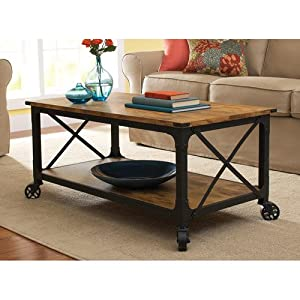


ID:             B00KXHCG48
Title:          Barcelona Coffee Table- Metal Vintage Legs
Description:    Coffee Table- This beautiful rustic coffee table is made from solid wood and vintage...
Price:          None


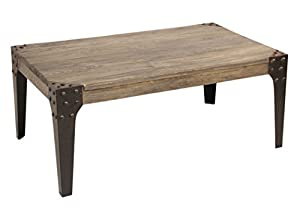


ID:             B007PQRXFM
Title:          Oriental Furniture Rush Grass Knotwork Coffee Table/Ottoman, Natural
Description:    Hand crafted tropical design round table. great casual style coffee table/ottoman wi...
Price:          156.59


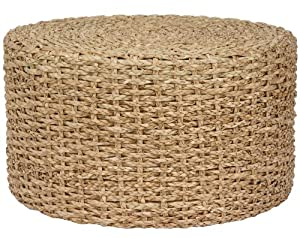


ID:             B00869NVRQ
Title:          Coaster Country Style Coffee Table
Description:    Add some country style to your room with this rustic coffee table, featuring a distr...
Price:          351.0


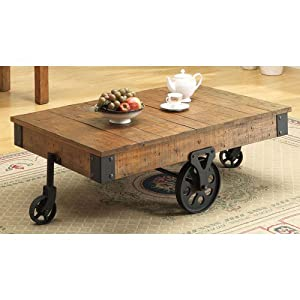


ID:             B004CVKVXY
Title:          Altra 3505096 Rustic Shaker Coffee Table, Oak
Description:    This light colored rustic piece will take you back to that comfortable place. A stur...
Price:          516.0


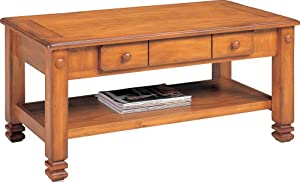

In [26]:
body = {
    "query": {
        "multi_match": {
            "query": "rustic coffee table",
            "fields": ["title", "description"]
        }
    }
}

res = es.search(index=index, body=body, size=5)

display_hits(res)

## Run Image Similarity Queries

Let's say we really like product `B00GG7LCIK` and want to find all of the tables that look similar to it.

Found 10000 hits in 71 ms

Title:          Set of 2 Black Bycast Leather Dining Parson Chairs
Description:    Set of 2 Dark Black Bycast Leather Dining Parson Chairs. This is a set of 2 parson c...
Price:          None
ID:             B000FCMT02
Score:          1.0


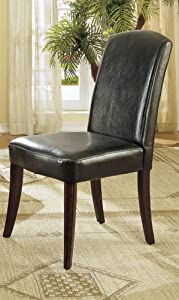


Title:          Extra Large Seat Dark Brown Leather Swivel Barstool with Crafted Arm and Backrest
Description:    Extra Large Seat Black Leather Swivel Barstool with Crafted Arm and Backrest is know...
Price:          None
ID:             B000FONVNY
Score:          0.014253214


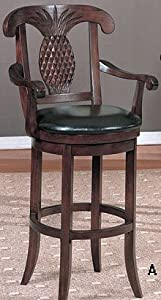


Title:          Signature Design by Ashley T864-3 Hatsuko Rectangular End Table
Description:    The stylish contemporary design of the Hatsuko accent table collection features a da...
Price:          147.19
ID:             B008YFJAQS
Score:          0.013539107


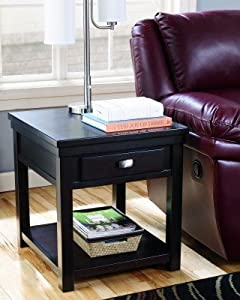


Title:          Set of 2 Contemporary Upholstered Dining Side Chair
Description:    Warm multi-colored upholstery wraps the seat and back panels of the Figueroa Side Ch...
Price:          None
ID:             B004TV5AKG
Score:          0.013487519


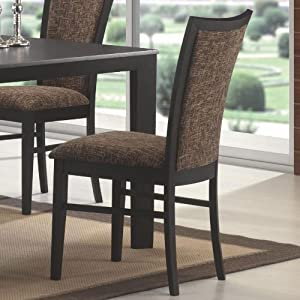


Title:          Flash Furniture XU-DGW0008VRT-MAH-BLKV-GG Hercules Series Mahogany Finished Vertical Slat Back Wooden Restaurant Chair with Black Vinyl Seat
Description:    Provide your customers with the ultimate dining experience by offering great food, s...
Price:          50.78
ID:             B007NWQHW8
Score:          0.01337444


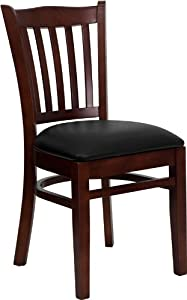


Title:          Powell Black Faux Leather Parsons Counter Stool, 24-Inch
Description:    The Black Faux Leather Parsons Counter Stool adds style and comfort to any kitchen, ...
Price:          None
ID:             B004LF8U1G
Score:          0.013246098


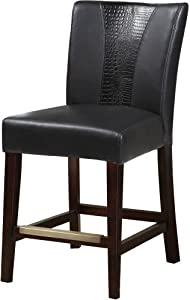


Title:          OSP Designs Metro Swivel Eco Leather Barstool, Espresso
Description:    Metro swivel barstool in espresso eco leather...
Price:          185.19
ID:             B004LQ1UKS
Score:          0.013064766


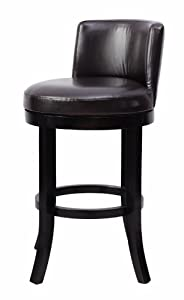


Title:          Shell and Leaf Coffee Table
Description:    Dimension: 52 1/2&quot;L x 30&quot;W x 19&quot;HFinish: Deep BrownMaterial: WoodCoff...
Price:          307.34
ID:             B000YFPAOC
Score:          0.012894572


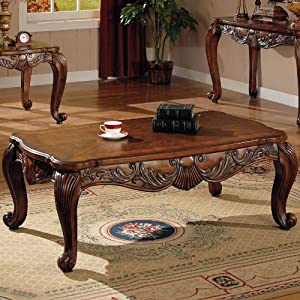


Title:          Set of 2 Dining Arm Chairs with Cushion Seat
Description:    POUNDEX-ARM CHAIR FOR F2049 great for any contemporary home dcor with its brown colo...
Price:          None
ID:             B000XKZPV6
Score:          0.012876386


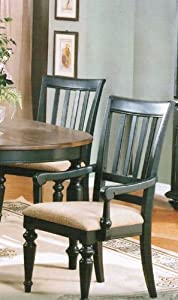


Title:          Mars Swivel Bar Stool, 30&quot;H SEAT, MOROCCAN BROWN
Description:    Create the perfect area to sit with your morning cup of coffee or relax and have dri...
Price:          None
ID:             B002OVV2C8
Score:          0.01272293


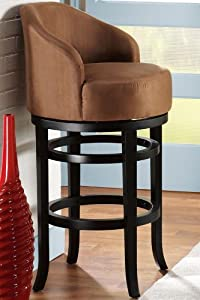

In [35]:
body = {
    "query": {
        "elastiknn_nearest_neighbors": {
            "vec": {
                "index": index,
                "field": "imVec",
                "id": "B000FCMT02"
            },
            "field": "imVec",
            "model": "exact",
            "similarity": "l2"
        }
    }
}

res = es.search(index=index, body=body, size=10)
display_hits(res)

## Combine Keyword and Image Similarity Queries

## Improve Performance with More Shards